## Advanced Model

In [67]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
engine = create_engine("postgresql:///kc_housing")
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import seaborn as sns

In [2]:
def pullsqldata():
    """This function pulls the necessary columns and rows from the PostGRES DB into a Pandas Dataframe in order 
    to continue with our EDA """
    
    engine = create_engine("postgresql:///kc_housing")
    query = """
                SELECT *
                FROM rpsale AS s
                INNER JOIN resbldg AS b ON CONCAT(s.Major,s.Minor) = CONCAT(b.Major, b.Minor)
                INNER JOIN parcel AS p ON CONCAT(s.Major,s.Minor) = CONCAT(p.Major,p.Minor)
                WHERE EXTRACT(YEAR FROM CAST(documentdate AS DATE)) = 2018
                    AND p.proptype = 'R'
                ;"""
    kc_df = pd.read_sql(sql = query, con = engine)
    return kc_df

def clean_data_intial(df):
    """ This function cleans the housing data by removing outliers, sale price == 0, and irrelevant columns. 
    """
    #We chose a minimum sale vale of 10000 and a maximium sale value of 2 sigma
    df_clean = df[(df['saleprice']>10000) & (df['saleprice'] <  (2*df['saleprice'].std())+df['saleprice'].mean())]
    #These are irrelevant or highly covariant columns
    columns_to_drop = ['documentdate',
                       'excisetaxnbr',
                       'recordingnbr',
                       'volume',
                       'page',
                       'platnbr',
                       'plattype',
                       'platlot',
                       'platblock',
                        'sellername',
                        'buyername',
                        'streetname',
                        'streettype',
                        'directionsuffix',
                        'buildingnumber',
                        'major',
                        'minor',
                        'bldggradevar',
                        'sqfthalffloor',
                        'sqft2ndfloor',
                        'sqftupperfloor',
                        'sqftunfinfull',
                        'sqftunfinhalf',
                        'sqfttotbasement',
                        'sqftfinbasement',
                        'brickstone',
                        'viewutilization',
                        'propname',
                        'platname',
                        'platlot',
                        'platblock',
                        'range',
                        'township',
                        'section',
                        'quartersection',
                        'area',
                        'subarea',
                        'specarea',
                        'specsubarea',
                        'levycode',
                        'districtname',
                        'currentzoning',
                        'topography',
                        'currentusedesignation',
                        'salewarning',
                        'wetland',
                        'stream',
                        'seismichazard',
                        'landslidehazard',
                        'address',
                        'airportnoise',
                        'contamination',
                        'dnrlease',
                         'coalminehazard',
                         'criticaldrainage',
                         'erosionhazard',
                         'landfillbuffer',
                         'hundredyrfloodplain',
                         'steepslopehazard',
                         'speciesofconcern',
                         'sensitiveareatract',
                         'daylightbasement',
                         'fraction',
                        'directionprefix', 'proptype','unbuildable', 'bldgnbr']
    df_clean.drop(columns=columns_to_drop, inplace = True)
    #The columns with Y or N need to be 1 or 0 to model
    df_clean['othernuisances'] = [i.strip() for i in df_clean['othernuisances']]
    df_clean.replace(('Y', 'N'), (1, 0), inplace=True)
    
    #To model the houses that take up more space of thier plot (smaller yard) we need a ratio feature
    #We assume an acturate metric of the house's footprint is the first floor plus any attached garage. This 
    #unfortunatley may not account for detached garages
    df_clean['footprint_ratio']=(df_clean['sqft1stfloor']+df_clean['sqftgarageattached'])/df_clean['sqftlot']
#     df_clean.drop(columns = 'sqft1stfloor', inplace = True)

    return df_clean

def find_highest_correlation(df, dep ='saleprice'):
    try:
        X = df.drop([dep], axis = 1)
    except:
        X = df
    Y = df[dep]
    
    num = 0
    for element in X.columns:
        a = pearsonr(list(X[element]),list(Y))
        if np.abs(a[0]) > num:
            num = a[0]
    for element in X.columns:
        a = pearsonr(list(X[element]),list(Y))
        if np.abs(a[0]) == num:
            return element

In [3]:
df = pullsqldata()
df_clean = clean_data_intial(df)

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/pandas/core/frame.py:4278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/

In [4]:
# drops triplexes from the dataframe
triplex = df_clean.loc[df_clean['nbrlivingunits'] >= 3]
df_clean.drop(triplex.index, inplace= True, axis=0) 
# create a duplex column, value of 1 is duplex, 0 is
df_clean['duplex'] = df_clean['nbrlivingunits'] - 1       

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [5]:
df_clean['duplex'].value_counts()

0.0    28305
1.0      352
Name: duplex, dtype: int64

In [6]:
df_clean.shape

(28657, 86)

In [7]:
df['othernuisances'] = [x.strip() for x in df['othernuisances']]
df.replace(('Y', 'N'), (1, 0), inplace=True)
df_clean.shape

(28657, 86)

### Base Model

In [8]:
base_model = df_clean[['saleprice','sqfttotliving', 'sqftlot', 'footprint_ratio', 'duplex']]


In [9]:
Ybase = base_model['saleprice']
Xbase = base_model.drop(['saleprice'], axis=1)

In [10]:
Xbase_int = sm.add_constant(Xbase)
model_base = sm.OLS(Ybase, Xbase_int).fit()
model_base.summary()

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     3125.
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:38:03   Log-Likelihood:            -4.0262e+05
No. Observations:               28657   AIC:                         8.053e+05
Df Residuals:                   28652   BIC:                         8.053e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.895e+05   5524.371     34.309      0.000    1.79e+05       2e+05
sqfttotliving     218.2217      2.037    107.114      0.000     214.228     222.215
sqftlot             0.1568      0.033      4.711      0.000       0.092       0.222
footprint_ratio  2.947e+05    1.5e+04     19.602      0.000    2.65e+05    3.24e+05
duplex           6.649e+04   1.64e+04      4.052      0.000    3.43e+04    9.87e+04
==============================================================================
Omnibus:                     3272.926   Durbin-Watson:                   0.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8767.244
Skew:                           0.644   Prob(JB):                         0.00
Kurtosis:                       5.385   Cond. No.                     5.45e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### determining the correlation between 'independent' functions

In [11]:
correlation_cut_off = .5

df_X = df_clean.drop(['saleprice'], axis = 1)



corr = df_X.corr() > correlation_cut_off


corr_list = []
for col in corr.columns:
    corr_v = corr[col][corr[col] == True].index.tolist()
    if len(corr_v) > 1:
        corr_list.append((col, corr_v))
    
corr_list
# for col in corr.columns:
#     if corr[col].sum() > 1:

#         corr_list.append(col)

[('nbrlivingunits', ['nbrlivingunits', 'duplex']),
 ('bldggrade', ['bldggrade', 'sqfttotliving', 'yrbuilt']),
 ('sqft1stfloor', ['sqft1stfloor', 'sqfttotliving']),
 ('sqfttotliving',
  ['bldggrade', 'sqft1stfloor', 'sqfttotliving', 'bedrooms', 'bathfullcount']),
 ('bedrooms', ['sqfttotliving', 'bedrooms']),
 ('bathfullcount', ['sqfttotliving', 'bathfullcount']),
 ('fpmultistory', ['fpmultistory', 'fpadditional']),
 ('fpadditional', ['fpmultistory', 'fpadditional']),
 ('yrbuilt', ['bldggrade', 'yrbuilt']),
 ('olympics', ['olympics', 'pugetsound']),
 ('territorial', ['territorial', 'pugetsound']),
 ('pugetsound', ['olympics', 'territorial', 'pugetsound']),
 ('smalllakerivercreek', ['smalllakerivercreek', 'wfntlocation']),
 ('wfntlocation',
  ['smalllakerivercreek', 'wfntlocation', 'wfntfootage', 'wfntbank']),
 ('wfntfootage', ['wfntlocation', 'wfntfootage', 'wfntbank']),
 ('wfntbank',
  ['wfntlocation',
   'wfntfootage',
   'wfntbank',
   'wfntrestrictedaccess',
   'tidelandshoreland']),

In [12]:
df_zip = df_clean[df_clean['zipcode'].str.contains ('98')]
num = '98075-8010'
df_zip['zipcode'] = df_clean['zipcode'].map(lambda x: x[0:5])


/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
df_zip.zipcode.value_counts()

98042    801
98023    714
98038    683
98058    641
98115    590
        ... 
98068      5
98000      2
98134      1
98009      1
98422      1
Name: zipcode, Length: 82, dtype: int64

In [14]:
df_zip_test = df_zip[['saleprice','zipcode']]


df_zip['zipcode'] = pd.Categorical(df_zip['zipcode'])
df_zip_test = pd.get_dummies(df_zip['zipcode'], prefix = 'zip')



/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [15]:
df_test = df_zip[['saleprice']]
df_test.join(df_zip_test, how = 'left')

Xzip = df_zip_test.iloc[:,1:]
Xzip

,zip_98001,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98009,zip_98010,...,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,zip_98224,zip_98288,zip_98354,zip_98422
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43732,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43735,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
X_int = sm.add_constant(Xzip)
model = sm.OLS(df_zip[['saleprice']], X_int).fit()
model.summary()

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(ax

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     281.9
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:38:04   Log-Likelihood:            -3.2630e+05
No. Observations:               23535   AIC:                         6.528e+05
Df Residuals:                   23453   BIC:                         6.534e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.245e+06    1.8e+05      6.917      0.000    8.92e+05     1.6e+06
zip_98001   -8.63e+05    1.8e+05     -4.784      0.000   -1.22e+06   -5.09e+05
zip_98002  -9.359e+05    1.8e+05     -5.185      0.000   -1.29e+06   -5.82e+05
zip_98003  -8.542e+05    1.8e+05     -4.733      0.000   -1.21e+06      -5e+05
zip_98004    9.01e+04   1.81e+05      0.497      0.619   -2.65e+05    4.46e+05
zip_98005  -1.911e+04   1.81e+05     -0.105      0.916   -3.75e+05    3.36e+05
zip_98006  -1.596e+05    1.8e+05     -0.884      0.376   -5.13e+05    1.94e+05
zip_98007  -3.623e+05   1.81e+05     -1.997      0.046   -7.18e+05   -6646.957
zip_98008  -3.654e+05   1.81e+05     -2.023      0.043   -7.19e+05   -1.14e+04
zip_98009  -5.953e+05   3.12e+05     -1.909      0.056   -1.21e+06    1.59e+04
zip_98010  -7.454e+05   1.82e+05     -4.103      0.000    -1.1e+06   -3.89e+05
zip_98011  -5.603e+05   1.81e+05     -3.097      0.002   -9.15e+05   -2.06e+05
zip_98014  -5.568e+05   1.81e+05     -3.071      0.002   -9.12e+05   -2.01e+05
zip_98019  -6.252e+05   1.81e+05     -3.456      0.001    -9.8e+05   -2.71e+05
zip_98022  -8.425e+05    1.8e+05     -4.668      0.000    -1.2e+06   -4.89e+05
zip_98023  -8.456e+05    1.8e+05     -4.690      0.000    -1.2e+06   -4.92e+05
zip_98024  -4.845e+05   1.82e+05     -2.658      0.008   -8.42e+05   -1.27e+05
zip_98027  -3.792e+05   1.81e+05     -2.100      0.036   -7.33e+05   -2.53e+04
zip_98028  -5.903e+05   1.81e+05     -3.267      0.001   -9.45e+05   -2.36e+05
zip_98029  -3.336e+05   1.81e+05     -1.846      0.065   -6.88e+05    2.07e+04
zip_98030   -8.47e+05   1.81e+05     -4.689      0.000    -1.2e+06   -4.93e+05
zip_98031  -8.177e+05   1.81e+05     -4.530      0.000   -1.17e+06   -4.64e+05
zip_98032  -8.832e+05   1.81e+05     -4.884      0.000   -1.24e+06   -5.29e+05
zip_98033  -9.748e+04    1.8e+05     -0.540      0.589   -4.51e+05    2.56e+05
zip_98034  -4.822e+05    1.8e+05     -2.674      0.008   -8.36e+05   -1.29e+05
zip_98038  -7.139e+05    1.8e+05     -3.960      0.000   -1.07e+06   -3.61e+05
zip_98039   2.959e+05   1.92e+05      1.544      0.123   -7.98e+04    6.72e+05
zip_98040   1.276e+05   1.81e+05      0.705      0.481   -2.27e+05    4.82e+05
zip_98042  -8.159e+05    1.8e+05     -4.526      0.000   -1.17e+06   -4.63e+05
zip_98045  -5.896e+05   1.81e+05     -3.266      0.001   -9.43e+05   -2.36e+05
zip_98047  -9.521e+05   1.83e+05     -5.200      0.000   -1.31e+06   -5.93e+05
zip_98050  -4.512e+05   2.04e+05     -2.210      0.027   -8.51e+05   -5.11e+04
zip_98051  -6.737e+05   1.84e+05     -3.654      0.000   -1.04e+06   -3.12e+05
zip_98052  -3.414e+05    1.8e+05     -1.892      0.058   -6.95e+05    1.22e+04
zip_98053  -3.192e+05   1.81e+05     -1.767      0.077   -6.73e+05    3.48e+04
zip_98055  -8.164e+05   1.81e+05     -4.520      0.000   -1.17e+06   -4.62e+05
zi

In [17]:
av_model1 = Xzip.join(base_model, how = 'left')

In [18]:
x_1 = av_model1.drop(['saleprice'], axis = 1)

X_int = sm.add_constant(x_1)
model = sm.OLS(av_model1[['saleprice']], X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     569.2
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:38:04   Log-Likelihood:            -3.2113e+05
No. Observations:               23535   AIC:                         6.424e+05
Df Residuals:                   23449   BIC:                         6.431e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.701e+05   1.45e+05      2.549      0.011    8.55e+04    6.55e+05
zip_98001       -3.472e+05   1.45e+05     -2.388      0.017   -6.32e+05   -6.23e+04
zip_98002       -3.304e+05   1.45e+05     -2.271      0.023   -6.16e+05   -4.53e+04
zip_98003       -3.225e+05   1.45e+05     -2.218      0.027   -6.07e+05   -3.75e+04
zip_98004        4.964e+05   1.46e+05      3.397      0.001     2.1e+05    7.83e+05
zip_98005        3.436e+05   1.46e+05      2.352      0.019    5.72e+04     6.3e+05
zip_98006        2.261e+05   1.45e+05      1.555      0.120   -5.88e+04    5.11e+05
zip_98007        1.299e+05   1.46e+05      0.889      0.374   -1.57e+05    4.17e+05
zip_98008        1.187e+05   1.46e+05      0.815      0.415   -1.67e+05    4.04e+05
zip_98009       -3.099e+05   2.51e+05     -1.236      0.216   -8.01e+05    1.81e+05
zip_98010        -2.38e+05   1.46e+05     -1.627      0.104   -5.25e+05    4.88e+04
zip_98011       -7.842e+04   1.46e+05     -0.538      0.591   -3.64e+05    2.07e+05
zip_98014       -1.555e+05   1.46e+05     -1.066      0.287   -4.42e+05    1.31e+05
zip_98019       -1.828e+05   1.46e+05     -1.255      0.209   -4.68e+05    1.03e+05
zip_98022       -3.165e+05   1.45e+05     -2.178      0.029   -6.01e+05   -3.16e+04
zip_98023       -3.391e+05   1.45e+05     -2.334      0.020   -6.24e+05   -5.43e+04
zip_98024       -1.104e+05   1.47e+05     -0.753      0.451   -3.98e+05    1.77e+05
zip_98027       -1532.1997   1.45e+05     -0.011      0.992   -2.87e+05    2.83e+05
zip_98028        -1.04e+05   1.46e+05     -0.714      0.475   -3.89e+05    1.81e+05
zip_98029        1.044e+05   1.46e+05      0.717      0.474   -1.81e+05     3.9e+05
zip_98030       -3.086e+05   1.46e+05     -2.120      0.034   -5.94e+05   -2.33e+04
zip_98031       -3.033e+05   1.45e+05     -2.085      0.037   -5.88e+05   -1.82e+04
zip_98032       -3.258e+05   1.46e+05     -2.236      0.025   -6.11e+05   -4.02e+04
zip_98033        3.573e+05   1.45e+05      2.457      0.014    7.22e+04    6.42e+05
zip_98034        2.098e+04   1.45e+05      0.144      0.885   -2.64e+05    3.06e+05
zip_98038       -2.554e+05   1.45e+05     -1.759      0.079    -5.4e+05    2.93e+04
zip_98039        8.011e+05   1.54e+05      5.189      0.000    4.99e+05     1.1e+06
zip_98040         4.92e+05   1.46e+05      3.377      0.001    2.06e+05    7.78e+05
zip_98042       -3.051e+05   1.45e+05     -2.101      0.036    -5.9e+05   -2.05e+04
zip_98045       -1.008e+05   1.45e+05     -0.693      0.488   -3.86e+05    1.84e+05
zip_98047       -3.447e+05   1.48e+05     -2.336      0.019   -6.34e+05   -5.55e+04
zip_98050       -8.744e+04   1.64e+05     -0.533      0.594   -4.09e+05    2.34e+05
zip_98051       -2.858e+05   1.48e+05     -1.926      0.054   -5.77e+05    4981.460
zip_98052        1.242e+05   1.45e+05      0.854      0.393

### checking to see if footprint ratio is better predictor than lotsize and footprint

In [19]:
for col in df_clean.columns:
    print(col)

saleprice
propertytype
principaluse
saleinstrument
afforestland
afcurrentuseland
afnonprofituse
afhistoricproperty
salereason
propertyclass
nbrlivingunits
zipcode
stories
bldggrade
sqft1stfloor
sqfttotliving
finbasementgrade
sqftgaragebasement
sqftgarageattached
sqftopenporch
sqftenclosedporch
sqftdeck
heatsystem
heatsource
bedrooms
bathhalfcount
bath3qtrcount
bathfullcount
fpsinglestory
fpmultistory
fpfreestanding
fpadditional
yrbuilt
yrrenovated
pcntcomplete
obsolescence
pcntnetcondition
condition
addnlcost
hbuasifvacant
hbuasimproved
presentuse
sqftlot
watersystem
sewersystem
access
streetsurface
restrictiveszshape
inadequateparking
pcntunusable
mtrainier
olympics
cascades
territorial
seattleskyline
pugetsound
lakewashington
lakesammamish
smalllakerivercreek
otherview
wfntlocation
wfntfootage
wfntbank
wfntpoorquality
wfntrestrictedaccess
wfntaccessrights
wfntproximityinfluence
tidelandshoreland
lotdepthfactor
trafficnoise
powerlines
othernuisances
nbrbldgsites
adjacentgolffairway
ad

In [20]:
# r^2 is 9
new_base_model = df_clean[['saleprice','sqfttotliving', 'sqftlot', 'sqft1stfloor', 'duplex']]

av_model2 = Xzip.join(new_base_model, how = 'left')

In [21]:
x_2 = av_model2.drop(['saleprice'], axis = 1)

X_int = sm.add_constant(x_2)
avmodel2 = sm.OLS(av_model2[['saleprice']], X_int).fit()
avmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     567.5
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:38:05   Log-Likelihood:            -3.2115e+05
No. Observations:               23535   AIC:                         6.425e+05
Df Residuals:                   23449   BIC:                         6.432e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.564e+05   1.45e+05      2.451      0.014    7.13e+04    6.41e+05
zip_98001     -3.429e+05   1.46e+05     -2.357      0.018   -6.28e+05   -5.77e+04
zip_98002     -3.284e+05   1.46e+05     -2.255      0.024   -6.14e+05    -4.3e+04
zip_98003     -3.197e+05   1.46e+05     -2.197      0.028   -6.05e+05   -3.44e+04
zip_98004      5.027e+05   1.46e+05      3.437      0.001    2.16e+05    7.89e+05
zip_98005      3.517e+05   1.46e+05      2.404      0.016     6.5e+04    6.38e+05
zip_98006        2.3e+05   1.46e+05      1.580      0.114   -5.53e+04    5.15e+05
zip_98007      1.323e+05   1.46e+05      0.904      0.366   -1.55e+05    4.19e+05
zip_98008      1.214e+05   1.46e+05      0.833      0.405   -1.64e+05    4.07e+05
zip_98009     -3.248e+05   2.51e+05     -1.295      0.195   -8.17e+05    1.67e+05
zip_98010     -2.335e+05   1.46e+05     -1.595      0.111   -5.21e+05    5.35e+04
zip_98011     -7.498e+04   1.46e+05     -0.514      0.607   -3.61e+05    2.11e+05
zip_98014     -1.504e+05   1.46e+05     -1.030      0.303   -4.37e+05    1.36e+05
zip_98019     -1.778e+05   1.46e+05     -1.219      0.223   -4.64e+05    1.08e+05
zip_98022     -3.102e+05   1.45e+05     -2.132      0.033   -5.95e+05   -2.51e+04
zip_98023     -3.362e+05   1.45e+05     -2.312      0.021   -6.21e+05   -5.12e+04
zip_98024     -1.016e+05   1.47e+05     -0.692      0.489   -3.89e+05    1.86e+05
zip_98027      6197.2132   1.46e+05      0.043      0.966   -2.79e+05    2.92e+05
zip_98028     -1.007e+05   1.46e+05     -0.691      0.490   -3.86e+05    1.85e+05
zip_98029      9.667e+04   1.46e+05      0.663      0.507   -1.89e+05    3.83e+05
zip_98030     -3.068e+05   1.46e+05     -2.106      0.035   -5.92e+05   -2.12e+04
zip_98031     -3.006e+05   1.46e+05     -2.064      0.039   -5.86e+05   -1.52e+04
zip_98032     -3.219e+05   1.46e+05     -2.207      0.027   -6.08e+05    -3.6e+04
zip_98033      3.595e+05   1.46e+05      2.469      0.014    7.42e+04    6.45e+05
zip_98034      2.169e+04   1.45e+05      0.149      0.881   -2.63e+05    3.07e+05
zip_98038     -2.555e+05   1.45e+05     -1.757      0.079    -5.4e+05    2.95e+04
zip_98039      8.092e+05   1.55e+05      5.237      0.000    5.06e+05    1.11e+06
zip_98040       4.98e+05   1.46e+05      3.414      0.001    2.12e+05    7.84e+05
zip_98042     -3.037e+05   1.45e+05     -2.089      0.037   -5.89e+05   -1.87e+04
zip_98045     -9.769e+04   1.46e+05     -0.671      0.502   -3.83e+05    1.88e+05
zip_98047     -3.385e+05   1.48e+05     -2.292      0.022   -6.28e+05    -4.9e+04
zip_98050     -7.908e+04   1.64e+05     -0.481      0.630   -4.01e+05    2.43e+05
zip_98051     -2.723e+05   1.48e+05     -1.834      0.067   -5.63e+05    1.88e+04
zip_98052      1.258e+05   1.46e+05      0.865      0.387   -1.59e+05    4.11e+05
zip_98053      8.785e+04   1.46e+05      0.603   

no noticable effect when switching the footprint lot ratio with the footprint and the lot individually. Will probably drop all in future test

### determine list of best correlating data

In [22]:
df_clean['bldggrade'] = df_clean['bldggrade'].astype(int) 
df_b = df_clean[['saleprice']]

df['bldggrade'] = pd.Categorical(df['bldggrade'])
df_bldg = pd.get_dummies(df['bldggrade'], prefix = 'bldg')
df_bldg

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,bldg_1.0,bldg_2.0,bldg_3.0,bldg_4.0,bldg_5.0,bldg_6.0,bldg_7.0,bldg_8.0,bldg_9.0,bldg_10.0,bldg_11.0,bldg_12.0,bldg_13.0,bldg_20.0
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43736,0,0,0,0,1,0,0,0,0,0,0,0,0,0
43737,0,0,0,0,0,0,0,0,1,0,0,0,0,0
43738,0,0,0,0,0,0,0,0,1,0,0,0,0,0
43739,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [23]:
av_model3 = av_model1.copy()
av_model3 = av_model3.join(df_bldg.iloc[:,4:], how = 'left')


In [24]:
x_3 = av_model3.drop(['saleprice'], axis = 1)

X_int = sm.add_constant(x_3)
avmodel3 = sm.OLS(av_model3[['saleprice']], X_int).fit()
avmodel3.summary()

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     594.0
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        16:38:05   Log-Likelihood:            -3.1997e+05
No. Observations:               23535   AIC:                         6.401e+05
Df Residuals:                   23440   BIC:                         6.409e+05
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4.491e+05   1.41e+05      3.180      0.001    1.72e+05    7.26e+05
zip_98001       -2.575e+05   1.38e+05     -1.860      0.063   -5.29e+05    1.38e+04
zip_98002       -2.432e+05   1.38e+05     -1.756      0.079   -5.15e+05    2.83e+04
zip_98003       -2.507e+05   1.38e+05     -1.811      0.070   -5.22e+05    2.07e+04
zip_98004        5.496e+05   1.39e+05      3.951      0.000    2.77e+05    8.22e+05
zip_98005        3.638e+05   1.39e+05      2.615      0.009    9.12e+04    6.36e+05
zip_98006        2.382e+05   1.38e+05      1.721      0.085   -3.31e+04    5.09e+05
zip_98007        1.784e+05   1.39e+05      1.282      0.200   -9.44e+04    4.51e+05
zip_98008        1.865e+05   1.39e+05      1.346      0.178   -8.51e+04    4.58e+05
zip_98009       -3.094e+05   2.39e+05     -1.297      0.195   -7.77e+05    1.58e+05
zip_98010       -1.759e+05   1.39e+05     -1.263      0.207   -4.49e+05    9.71e+04
zip_98011       -1.613e+04   1.39e+05     -0.116      0.907   -2.88e+05    2.56e+05
zip_98014       -7.641e+04   1.39e+05     -0.550      0.582   -3.49e+05    1.96e+05
zip_98019       -1.123e+05   1.39e+05     -0.810      0.418   -3.84e+05    1.59e+05
zip_98022        -2.33e+05   1.38e+05     -1.684      0.092   -5.04e+05    3.82e+04
zip_98023       -2.757e+05   1.38e+05     -1.993      0.046   -5.47e+05   -4607.495
zip_98024        -4.11e+04    1.4e+05     -0.295      0.768   -3.15e+05    2.32e+05
zip_98027        4.311e+04   1.38e+05      0.311      0.756   -2.28e+05    3.14e+05
zip_98028        -2.51e+04   1.39e+05     -0.181      0.856   -2.97e+05    2.47e+05
zip_98029        1.136e+05   1.39e+05      0.819      0.413   -1.58e+05    3.85e+05
zip_98030       -2.205e+05   1.39e+05     -1.591      0.112   -4.92e+05    5.11e+04
zip_98031       -2.201e+05   1.38e+05     -1.589      0.112   -4.92e+05    5.14e+04
zip_98032       -2.427e+05   1.39e+05     -1.750      0.080   -5.15e+05    2.92e+04
zip_98033        4.024e+05   1.38e+05      2.906      0.004    1.31e+05    6.74e+05
zip_98034        9.791e+04   1.38e+05      0.708      0.479   -1.73e+05    3.69e+05
zip_98038       -1.832e+05   1.38e+05     -1.325      0.185   -4.54e+05    8.78e+04
zip_98039         8.28e+05   1.47e+05      5.634      0.000     5.4e+05    1.12e+06
zip_98040        4.986e+05   1.39e+05      3.594      0.000    2.27e+05     7.7e+05
zip_98042       -2.297e+05   1.38e+05     -1.661      0.097   -5.01e+05    4.13e+04
zip_98045       -3.827e+04   1.38e+05     -0.276      0.782    -3.1e+05    2.33e+05
zip_98047       -2.537e+05    1.4e+05     -1.806      0.071   -5.29e+05    2.16e+04
zip_98050        -7.31e+04   1.56e+05     -0.468      0.640   -3.79e+05    2.33e+05
zip_98051       -2.177e+05   1.41e+05     -1.541      0.123   -4.95e+05    5.92e+04
zip_98052        1.703e+05   1.38e+05      1.230      0.219

### check zipcode for normal distribution

In [26]:
df_sale = df_clean['saleprice']

In [74]:
zip_res = Xzip.join(df_sale, how = 'left')




lookup_dict = {}
for col in zip_res.columns:
    try:
        index = int(col[-3:])
        search_string = col[-3:]
        amount = int(zip_res[zip_res[col]== True]['saleprice'].mean())
        span = float(zip_res[zip_res[col]== True]['saleprice'].std())
        lookup_dict[col] = (amount, span)
    except:
        continue
        


error_list = []       
for col in zip_res.columns:
    try:
        df_filtered = zip_res[zip_res[col]== True]
        amount = df_filtered['saleprice'].mean()
        span = float(df_filtered['saleprice'].std())
        df_filtered['sigma_difference'] = (df_filtered['saleprice'] - amount)/span
        a = list(df_filtered['sigma_difference'])
        error_list.extend(a)

        
    except:
        continue       

        

/Users/lucasblasdel/opt/anaconda3/envs/learn-env/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


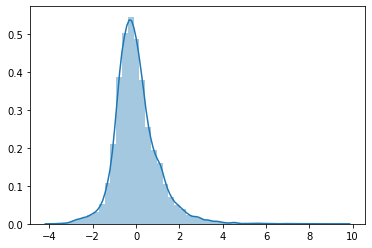

In [80]:
info = list(filter(lambda x: np.abs(x)> 0, error_list))
sns.distplot(info)

In [81]:
lookup_dict

{'zip_98001': (382299, 115902.34662302973),
 'zip_98002': (309339, 84077.62286627582),
 'zip_98003': (391080, 143091.10908321402),
 'zip_98004': (1335368, 487749.69128576695),
 'zip_98005': (1226165, 313967.2387728881),
 'zip_98006': (1085702, 368065.0954631843),
 'zip_98007': (882941, 351779.3605545098),
 'zip_98008': (879868, 292544.39955027954),
 'zip_98009': (649995, nan),
 'zip_98010': (499921, 284791.08172019944),
 'zip_98011': (684970, 178985.78592112724),
 'zip_98014': (688436, 307941.8108321855),
 'zip_98019': (620064, 212646.11570540667),
 'zip_98022': (402769, 174682.81873662543),
 'zip_98023': (399705, 138174.5266356886),
 'zip_98024': (760765, 364200.99789579946),
 'zip_98027': (866073, 289576.42607644945),
 'zip_98028': (654933, 199390.32220512407),
 'zip_98029': (911648, 216325.59144949637),
 'zip_98030': (398280, 116241.41197454897),
 'zip_98031': (427534, 139782.21515868124),
 'zip_98032': (362110, 105391.89197723154),
 'zip_98033': (1147788, 405453.76624157664),
 'zip

already deleted


<ErrorbarContainer object of 3 artists>

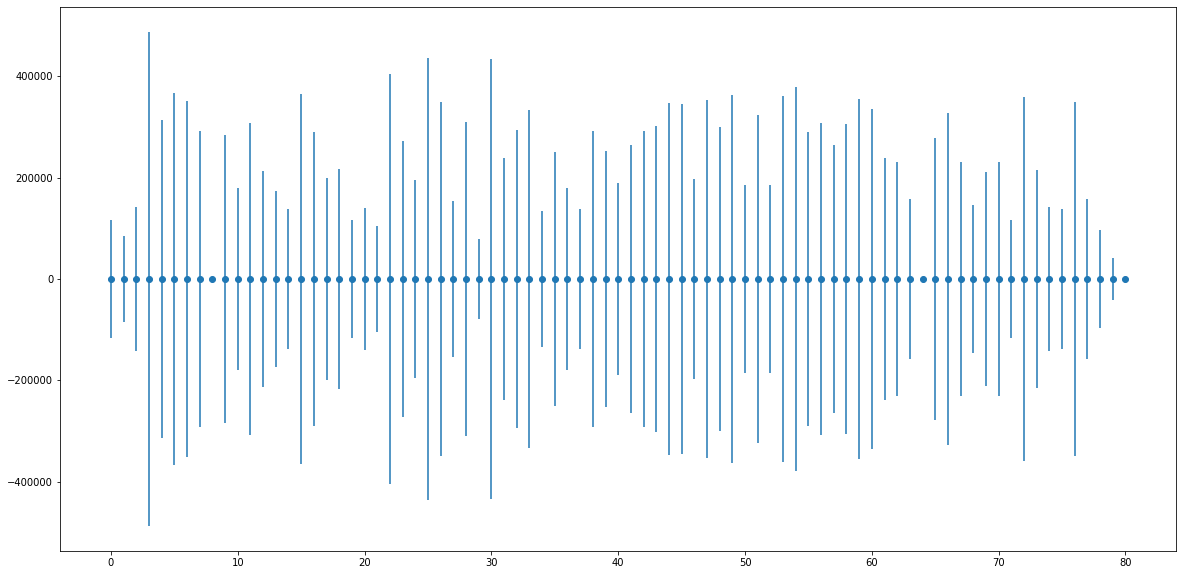

In [96]:
try:
    del lookup_dict[zip_98009]
    del lookup_dict[zip_98422]
    del lookup_dict[zip_98134]
    print('all deleted')
except:
    print('already deleted')

fig = plt.figure(figsize = (20,10))
x = list(range(len(lookup_dict.values())))
y = [0]*len(x)
# y = [x[0] for x in lookup_dict.values()]
yerr = [x[1] for x in lookup_dict.values()]

plt.errorbar(x, y, yerr=yerr, label='both limits (default)', fmt='o')

# plt.errorbar(x, y + 2, yerr=yerr, uplims=True, label='uplims=True')

# plt.errorbar(x, y + 1, yerr=yerr, uplims=True, lolims=True,
#              label='uplims=True, lolims=True')

# upperlimits = [True, False] * 5
# lowerlimits = [False, True] * 5
# plt.errorbar(x, y, yerr=yerr, uplims=upperlimits, lolims=lowerlimits,
#              label='subsets of uplims and lolims')

# plt.legend(loc='lower right')